In [12]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [13]:
# Load the growth factor and forex data
growth_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/growth_updated.csv')
forex_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/forex_yoy.csv')

# Combine the growth factor with the forex rate data
data = pd.merge(growth_data, forex_data, how="inner").set_index('Unnamed: 0')
data.index.name="Date"
data.index = pd.to_datetime(data.index)

In [14]:
# Ensure data is stationary
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

adf_test(data['growth'], 'Growth')
adf_test(data['USD/CNY Central Parity Rate'], 'USD/CNY Central Parity Rate')

# If non-stationary, difference the series
data_diff = data.diff().dropna()
adf_test(data_diff['growth'], 'Growth Differenced')
adf_test(data_diff['USD/CNY Central Parity Rate'], 'USD/CNY Central Parity Rate Differenced')

ADF Statistic for Growth: -3.16789952215672
p-value for Growth: 0.021919607123245154
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625
ADF Statistic for USD/CNY Central Parity Rate: -2.9601792088030576
p-value for USD/CNY Central Parity Rate: 0.0387842354984773
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625
ADF Statistic for Growth Differenced: -3.7612944344306265
p-value for Growth Differenced: 0.003329098241071824
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625
ADF Statistic for USD/CNY Central Parity Rate Differenced: -4.312455125342288
p-value for USD/CNY Central Parity Rate Differenced: 0.0004226612227271856
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625


In [15]:
data_diff = pd.concat([data['growth'].diff().dropna(), data['USD/CNY Central Parity Rate'].diff().dropna()], axis=1)
data_diff.columns = ['Growth Differenced', 'USD/CNY Central Parity Rate Differenced']

In [16]:
model = VAR(data_diff)
lag_order = model.select_order(maxlags=15)
print(lag_order.summary())

optimal_lag = lag_order.aic
print(f'Optimal Lag Order: {optimal_lag}')

# Fit the VAR model with the optimal lag order
model_fitted = model.fit(optimal_lag)
print(model_fitted.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.703       2.742       14.93       2.719
1        2.582      2.698*       13.22      2.629*
2        2.598       2.792       13.44       2.677
3        2.593       2.864       13.37       2.703
4        2.625       2.974       13.81       2.767
5        2.653       3.080       14.21       2.826
6        2.662       3.166       14.33       2.866
7        2.654       3.236       14.23       2.890
8        2.661       3.320       14.33       2.929
9        2.696       3.432       14.85       2.995
10       2.674       3.488       14.54       3.004
11       2.656       3.548       14.30       3.018
12       2.508       3.477       12.35       2.902
13      2.501*       3.547      12.27*       2.926
14       2.530       3.655       12.66       2.987
15       2.570       3.772       13.20       3.058
-------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [17]:
# Check residuals
residuals = model_fitted.resid

# Ensure residuals are white noise
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply Ljung-Box test for each residual series separately
for i, col in enumerate(residuals.columns):
    lb_test = acorr_ljungbox(residuals[col], lags=[10], return_df=True)
    print(f'Residuals for {col}:')
    print(lb_test)
    print('\n')

Residuals for Growth Differenced:
     lb_stat  lb_pvalue
10  0.717095   0.999963


Residuals for USD/CNY Central Parity Rate Differenced:
     lb_stat  lb_pvalue
10  0.841359   0.999923




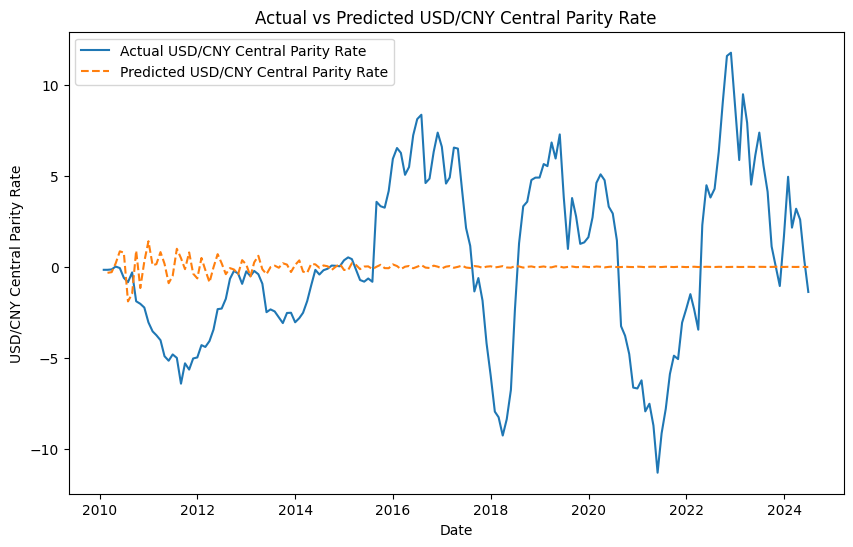

In [18]:
# Forecast
forecast_steps = len(data_diff)
forecast_input = data_diff.values[-optimal_lag:]
forecast_diff = model_fitted.forecast(y=forecast_input, steps=forecast_steps)

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast_diff, index=data_diff.index[-forecast_steps:], columns=data_diff.columns)

# Revert differencing to get actual forecast values
forecast_values = data.iloc[-1].values + forecast_df.cumsum().values

# Create a DataFrame for the actual forecast values
predicted_df = pd.DataFrame(forecast_values, index=forecast_df.index, columns=['Predicted Growth', 'Predicted USD/CNY Central Parity Rate'])

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['USD/CNY Central Parity Rate'], label='Actual USD/CNY Central Parity Rate')
plt.plot(forecast_df['USD/CNY Central Parity Rate Differenced'], label='Predicted USD/CNY Central Parity Rate', linestyle='--')
plt.title('Actual vs Predicted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.legend()
plt.show()

In [19]:
predicted_df

,Predicted Growth,Predicted USD/CNY Central Parity Rate
Date,,
2010-02-28,1.034176,-1.705540
2010-03-31,0.623064,-1.995579
2010-04-30,1.433739,-1.802653
2010-05-31,0.672713,-0.947279
2010-06-30,-1.340796,-0.163598
...,...,...
2024-02-29,22.121413,-1.511273
2024-03-31,22.244435,-1.515758
2024-04-30,22.370575,-1.514470


In [20]:
# Load the actual data
actual_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/forex_rate.csv').set_index('Unnamed: 0')
actual_data.index.name="Date"
actual_data.index = pd.to_datetime(actual_data.index)

In [21]:
# Ensure that the predicted YoY changes and the actual data overlap correctly
overlap_index = actual_data.index.intersection(forecast_df.index)
aligned_actual = actual_data.loc[overlap_index]
aligned_predicted_yoy = forecast_df.loc[overlap_index]

In [22]:
forecast_df

,Growth Differenced,USD/CNY Central Parity Rate Differenced
Date,,
2010-02-28,0.625722,-0.325977
2010-03-31,-0.411112,-0.290039
2010-04-30,0.810675,0.192926
2010-05-31,-0.761027,0.855374
2010-06-30,-2.013508,0.783681
...,...,...
2024-02-29,0.117993,-0.001367
2024-03-31,0.123022,-0.004485
2024-04-30,0.126140,0.001287


In [23]:
# Reconstruct the predicted actual values
predicted_actual_values = [aligned_actual['USD/CNY Central Parity Rate'].iloc[0]]
for change in aligned_predicted_yoy['USD/CNY Central Parity Rate Differenced'][1:]:
    new_value = predicted_actual_values[-1] * (1 + change / 100)
    predicted_actual_values.append(new_value)

# Create a DataFrame for the predicted actual values
predicted_actual_df = pd.DataFrame(predicted_actual_values, index=overlap_index, columns=['Predicted USD/CNY Central Parity Rate'])

In [24]:
# Display the predicted actual values
predicted_actual_df

,Predicted USD/CNY Central Parity Rate
Date,
2010-02-28,6.826900
2010-03-31,6.807099
2010-04-30,6.820232
2010-05-31,6.878570
2010-06-30,6.932477
...,...
2024-02-29,6.833523
2024-03-31,6.833217
2024-04-30,6.833305


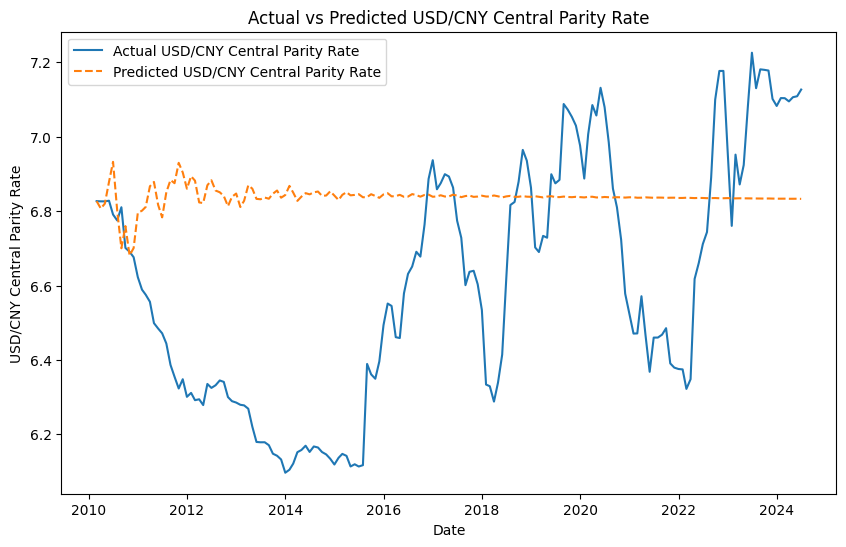

In [25]:
# Plot the actual vs predicted actual values
plt.figure(figsize=(10, 6))
plt.plot(aligned_actual['USD/CNY Central Parity Rate'], label='Actual USD/CNY Central Parity Rate')
plt.plot(predicted_actual_df['Predicted USD/CNY Central Parity Rate'], label='Predicted USD/CNY Central Parity Rate', linestyle='--')
plt.title('Actual vs Predicted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.legend()
plt.show()

In [101]:
# Define time series split
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_lag = 0

# Hyperparameter tuning for lag order
for lag in range(1, 16):
    mse_list = []
    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model = VAR(train)
        result = model.fit(lag)
        forecast = result.forecast(train.values[-lag:], steps=len(test))
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)
        mse = mean_squared_error(test['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
        mse_list.append(mse)
    
    avg_mse = np.mean(mse_list)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_lag = lag

print(f'Best Lag Order: {best_lag}, Best MSE: {best_mse}')

Best Lag Order: 5, Best MSE: 31.07345967698736


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

In [102]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Fit the VAR model with the best lag order
model = VAR(train_data)
result = model.fit(best_lag)
print(result.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jul, 2024
Time:                     10:53:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.66664
Nobs:                     134.000    HQIC:                   2.38421
Log likelihood:          -505.064    FPE:                    8.94966
AIC:                      2.19087    Det(Omega_mle):         7.64328
--------------------------------------------------------------------
Results for equation growth
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.223368         0.227152           -0.983           0.325
L1.growth                              1.304360         0.090439           14.423        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [103]:
# Forecasting
forecast_steps = len(test_data)
forecast = result.forecast(train_data.values[-best_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=train_data.columns)

In [104]:
# Calculate the mean squared error for the forex rate
mse = mean_squared_error(test_data['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 22.890934620827057


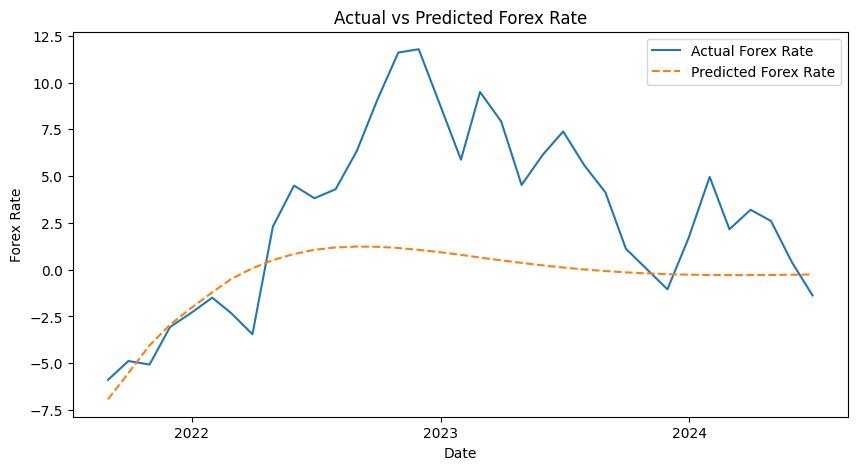

In [105]:
# Plot the actual vs predicted forex rates
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data['USD/CNY Central Parity Rate'], label='Actual Forex Rate')
plt.plot(forecast_df.index, forecast_df['USD/CNY Central Parity Rate'], label='Predicted Forex Rate', linestyle='--')

# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.title('Actual vs Predicted Forex Rate')
plt.xlabel('Date')
plt.ylabel('Forex Rate')
plt.show()